BDS^3
=====

## Реконструкція біофізичних властивостей кальцій-зв'язуючих білків за результами конфокальної мікроскопії
---
_Borys Olifirov, 07.2023, Uzhhorod_

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import sympy as sp

import numpy as np
from numpy import ma

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology

from scipy.ndimage import measurements
from scipy import signal

# 1. Біофізика процесу зв'язування іонів кальцію
---

## Зв'язування одного ліганду. Ізотерма Ленгмюра

Рівняння зв'язування білком __P__ одного ліганда __L__ (реакція другого порядку):
$$
P + L \rightleftharpoons PL
$$

Загальна концентрація білка (__[P]0__) та ліганда (__[L]0__) є сумої концентрації їх вільних (__[P]__, __[L]__) та зв'язаних (__[PL]__) форм:
$$
[P]_0 = [P] + [PL] \\
[L]_0 = [L] + [PL]
$$


$$
K_d = \frac{[P] \cdot [L]}{[PL]}
$$




In terms of the concentration of protein bounded form __[PL]__ or fraction of bound protein __Y__ we can rewrite the equation:
$$
Y = \frac{[PL]}{[P]_0}
$$

$$
[PL] = [P]_0 \frac{[L]}{K_d + [L]} \Leftrightarrow Y = \frac{[L]}{K_d + [L]} 
$$

In [ ]:
# параметри моделі
Kd_1_val = 0.05
Kd_2_val = 0.25
Kd_3_val = 0.8

c_l = np.arange(0, 1, 0.01)  # масив значень концентранції ліганда, від 0 до 1

# модель рівняння Ленгмюра
K_d, C_L = sp.symbols('K_a, C_l')
Y = sp.Function('Y')(C_L)
lang_eq = sp.Eq(Y, C_L/(C_L + K_d))

sp.pprint(lang_eq)

lang_eq_sol_Kd_1 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_1_val}).rhs, 'numpy') 
lang_eq_sol_Kd_2 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_2_val}).rhs, 'numpy') 
lang_eq_sol_Kd_3 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_3_val}).rhs, 'numpy') 

# відображення графіків
plt.figure(figsize=(15,6))
plt.plot(c_l, lang_eq_sol_Kd_1(c_l), label=f'Kd={Kd_1_val}')
plt.vlines(x=Kd_1_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_2(c_l), label=f'Kd={Kd_2_val}')
plt.vlines(x=Kd_2_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_3(c_l), label=f'Kd={Kd_3_val}')
plt.vlines(x=Kd_3_val, ymin=0, ymax=0.5, linestyles='--')

plt.hlines(y=0.5, xmin=0, xmax=Kd_3_val, linestyles='--', color='k')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

## Зв'язування декілької лігандів та кооперетивність. Рівняння Хіла

$$
Y = \frac{[L]^h}{K_d + [L]^h} = \frac{[L]^h}{K_A^n + [L]^h}
$$

$$
\log(\frac{Y}{1-Y}) = h \log[L] + \log K_A
$$

In [ ]:
# c_l = np.arange(0, 1, 0.01)
h_list = [1, 1.5, 2, 5]
K_A_val = 0.25

h, K_A, C_L = sp.symbols('h  K_a C_ion')
Y = sp.Function('Y')(C_L)
hill_eq = sp.Eq(Y, C_L**h/(K_A**h + C_L**h))
hill_eq_ln = sp.Eq(sp.log(Y/(1-Y)), h * sp.log(C_L) + sp.log(K_A))

sp.pprint(hill_eq, use_unicode=True)
sp.pprint(hill_eq_ln, use_unicode=True)

hill_profiles_dict = {}
hill_ln_dict = {}
for h_val in h_list:
	hill_eq_sol = sp.lambdify(C_L, hill_eq.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_ln_sol = sp.lambdify(C_L, hill_eq_ln.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_profiles_dict.update({h_val:hill_eq_sol(c_l)})
	hill_ln_dict.update({h_val:hill_ln_sol(c_l)})

# відображення графіків
plt.figure(figsize=(15,6))
for h_prof in hill_profiles_dict.keys():
	plt.plot(c_l, hill_profiles_dict[h_prof], label=f'h={h_prof}')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

# plt.figure(figsize=(15,6))
# for h_prof in hill_ln_dict.keys():
# 	plt.plot(c_l, hill_ln_dict[h_prof], label=f'h={h_prof}')

# plt.xlabel('log([L])')
# plt.ylabel('log(Y/(1-Y))')

# plt.legend()
# plt.show()

In [ ]:
n, K_D, C_ca = sp.symbols('n  K_a C_ion')
Y = sp.Function('Y')(C_ca)
hill_eq = sp.Eq(Y, C_ca**n/(K_D + C_ca**n))
hill_sol_assemblage = [sp.lambdify(C_ca, hill_eq.subs({n : n_val, K_D : 0.25}).rhs, "numpy") for n_val in [1, 2, 3, 4]]

sp.pprint(hill_eq, use_unicode=True)

# відображення графіків
plt.figure(figsize=(15,6))
for i in range(0, len(hill_sol_assemblage)):
	plt.plot(c_l, hill_sol_assemblage[i](c_l), label=f'n={[1, 1.5, 2, 5][i]}')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

## Похибка рівння Хіла. Рівняння Адера

$$
$$

# 2. Багатовимірні массиви та структура мікроскопічних даних
---

## Приклади

## Аналіз даних

#### Завантаження зображень та розділення каналів

In [26]:
# завантаження зображень
img_raw = io.imread("data/cell6.tif")
print(img_raw.shape)


# розділення окремих каналів
ch0_img_raw = img_raw[0]
ch1_img_raw = img_raw[1]
print(ch0_img_raw.shape) 

(2, 30, 256, 256)
(30, 256, 256)


#### Проекції серії знімків

Проекція максимальної інтенсивності пікселів

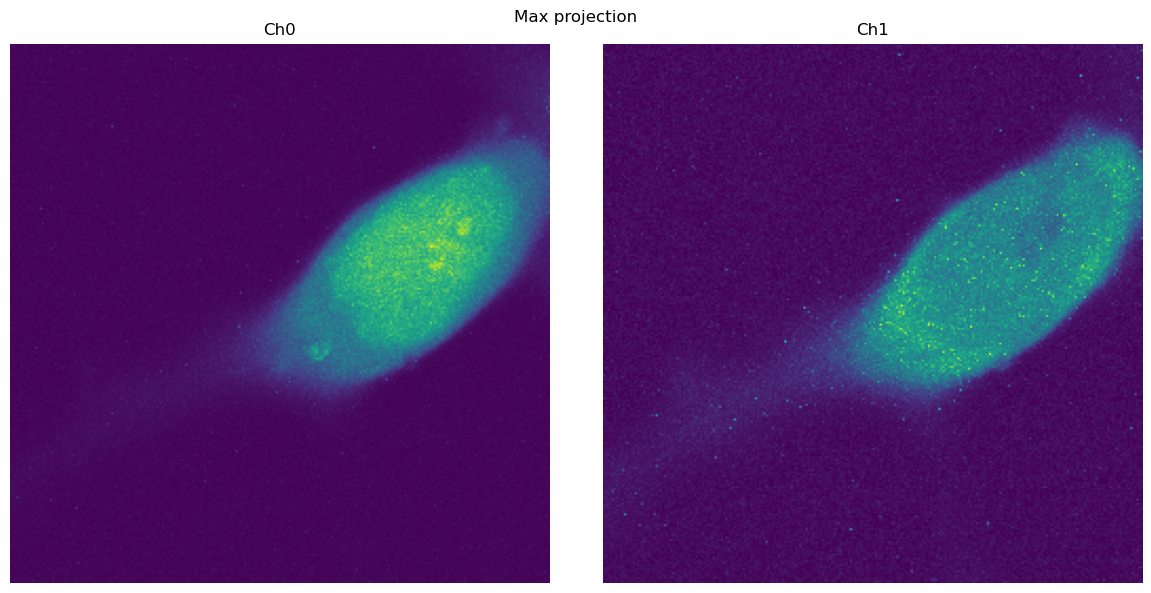

In [27]:
# проекції максимума для окремих каналів
ch0_img_raw_max = np.max(ch0_img_raw, axis=0)
ch1_img_raw_max = np.max(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_max)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_max)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Max projection')
plt.tight_layout()
plt.show()

Проекція середньої інтенсивності пікселів

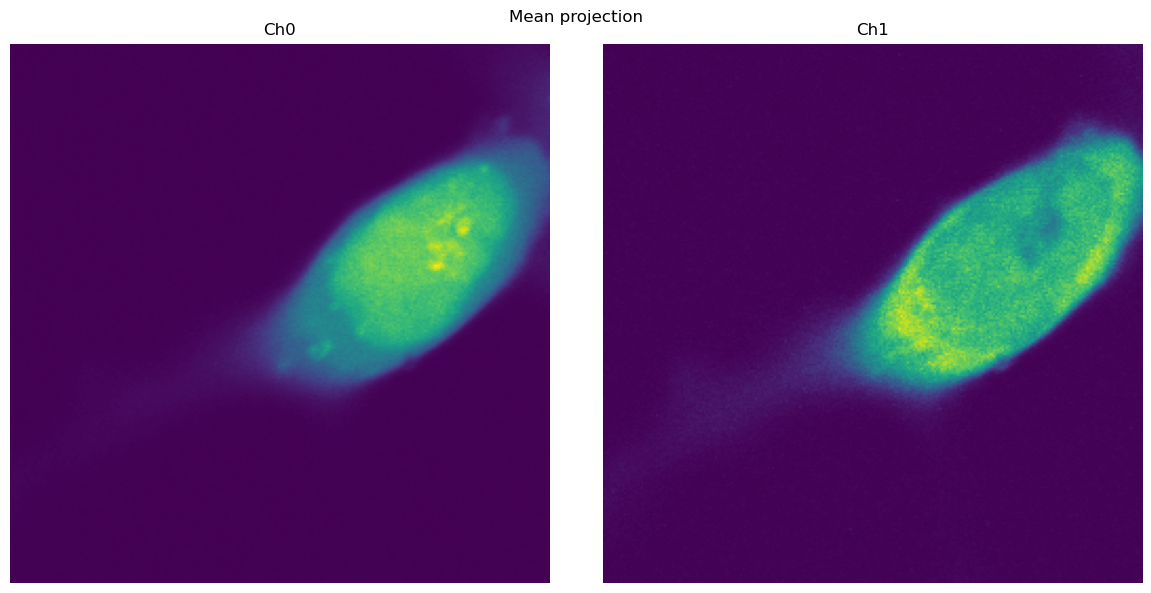

In [28]:
# проекції максимума для окремих каналів
ch0_img_raw_mean = np.mean(ch0_img_raw, axis=0)
ch1_img_raw_mean = np.mean(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_mean)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_mean)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Mean projection')
plt.tight_layout()
plt.show()

#### Кроп серії зображення

Вибір регіону клітини в кадрі

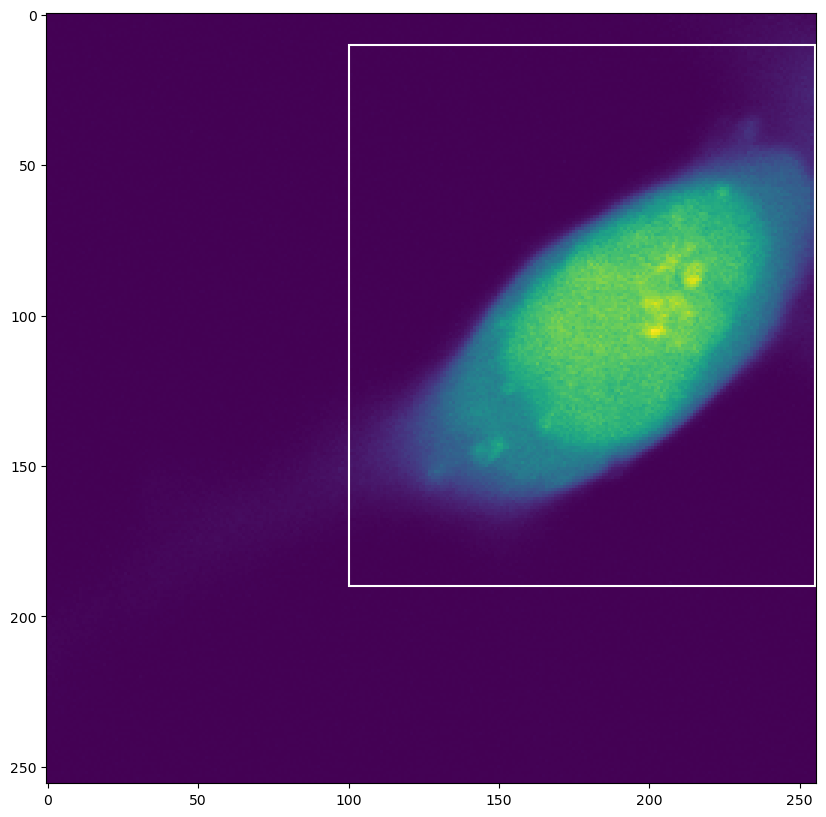

In [33]:
# регіон кропу
# x_start, x_end, y_start, y_end = 5, 160, 20, 190  # для файлу cell5
x_start, x_end, y_start, y_end = 10, 180, 100, 155  # для файлу cell6
# x_start, x_end, y_start, y_end = 40, 200, 100, 120  # для файлу cell7


crop_rect = patches.Rectangle((y_start, x_start), y_end, x_end,
                              linewidth=1.5, edgecolor='white', facecolor='none')

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ch0_img_raw_mean)
ax.add_patch(crop_rect)
plt.show()

Кроп всієї серії зображень для кожного з каналів

(30, 180, 155)


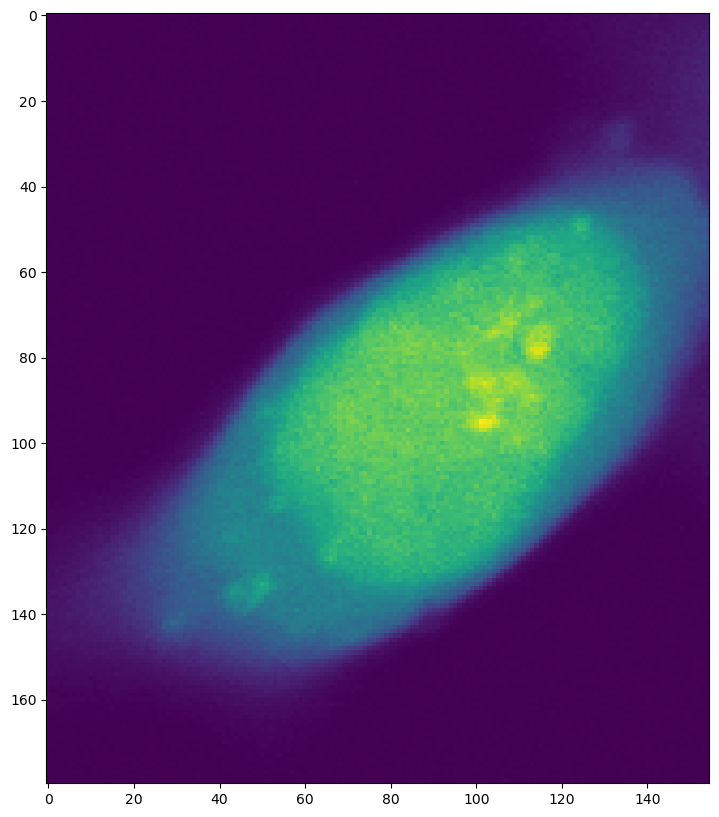

In [34]:
ch0_img_raw_crop = ch0_img_raw[:, x_start:x_start+x_end, y_start:y_start+y_end]
ch1_img_raw_crop = ch1_img_raw[:, x_start:x_start+x_end, y_start:y_start+y_end]
print(ch0_img_raw_crop.shape)


# plot
plt.figure(figsize=(10,10))
plt.imshow(np.mean(ch0_img_raw_crop, axis=0))
plt.show()

# 3. Фільтри, маски та морфологічні оператори
---

## Приклади

- Стркуктурний елемент
- Згортка
- Медіанний фільтр та фільтр Гаусу
- Фіксований поріг та булева маска
- Гістограма зображення
- Ерозія та діляція
- Відкривання та закривання

## Аналіз даних

#### Детекція та сегментація клітини з використанням мульти-Отсу

"Контрольне" зображення для детекції клітини

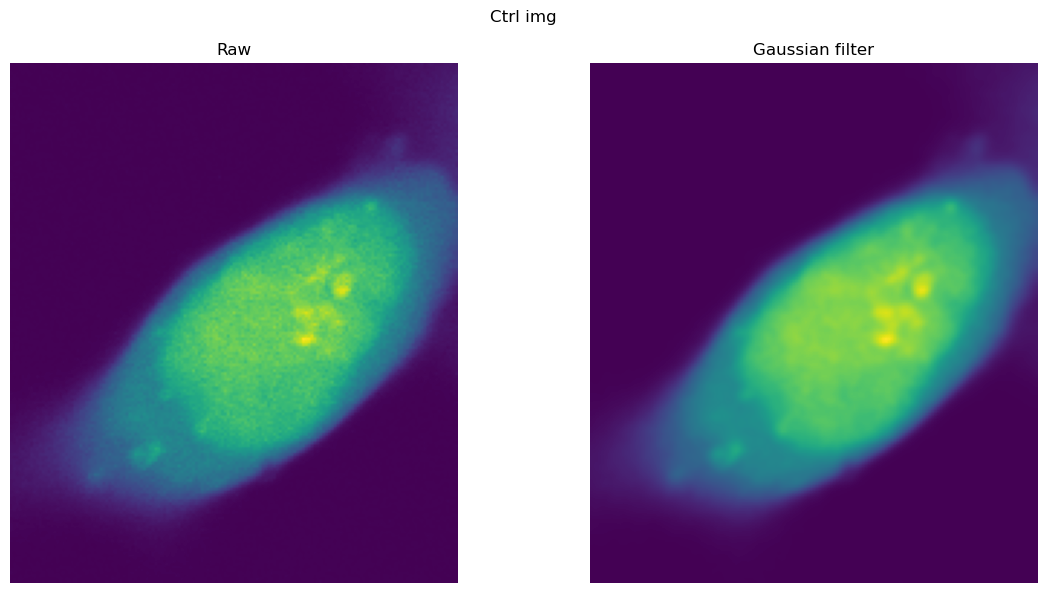

In [35]:
# контрольне зображення для детекції
cell_det_img_raw = np.mean(ch0_img_raw_crop, axis=0)

# фільтрування контрольного зображення
cell_det_img = filters.gaussian(cell_det_img_raw, sigma=1)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # сире контрольне зображення
ax0.imshow(cell_det_img_raw)
ax0.set_title('Raw')
ax0.axis('off')

ax1 = plt.subplot(122)  # контрольне зображення після застосування фільтра Гауса
ax1.imshow(cell_det_img)
ax1.set_title('Gaussian filter')
ax1.axis('off')

plt.suptitle('Ctrl img')
plt.tight_layout()
plt.show()

Обчислення порогів мульти-Отсу

[ 555.46190739 1261.86700766]


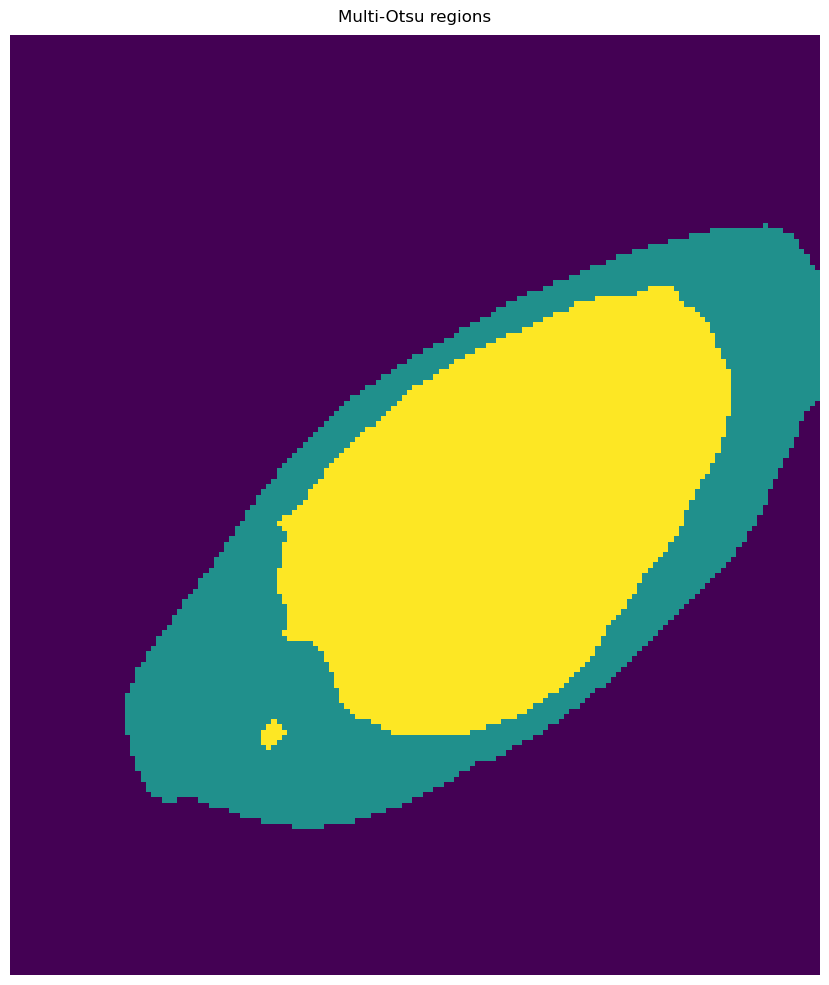

In [36]:
# отримання порогів мульти-Отсу
thresholds = filters.threshold_multiotsu(cell_det_img)
print(thresholds)

# розмежування регіонів за пороговими значеннями
regions_img = np.digitize(cell_det_img, bins=thresholds)


# plot
plt.figure(figsize=(10,10))
plt.imshow(regions_img)  # регіони за порогами мульти-Отсу
plt.suptitle('Multi-Otsu regions')
plt.axis('off')
plt.tight_layout()
plt.show()

Побудова масок окремих регіонів

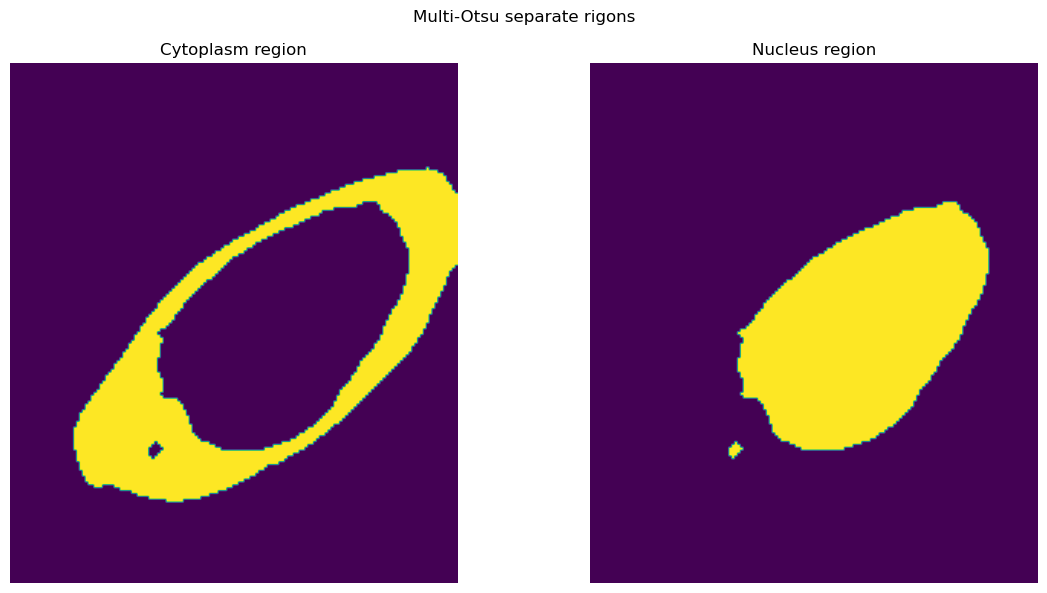

In [37]:
# булеві маски окремих регіонів
cytoplasm_mask_raw = regions_img == 1
nucleus_mask_raw = regions_img == 2


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask_raw)
ax0.set_title('Cytoplasm region')
ax0.axis('off')

ax1 = plt.subplot(122)  # регіон ядра
ax1.imshow(nucleus_mask_raw)
ax1.set_title('Nucleus region')
ax1.axis('off')

plt.suptitle('Multi-Otsu separate rigons')
plt.tight_layout()
plt.show()

#### Побудова масок цитоплазматичного регіону клітини та цілої клітини

Модифікація регіонів

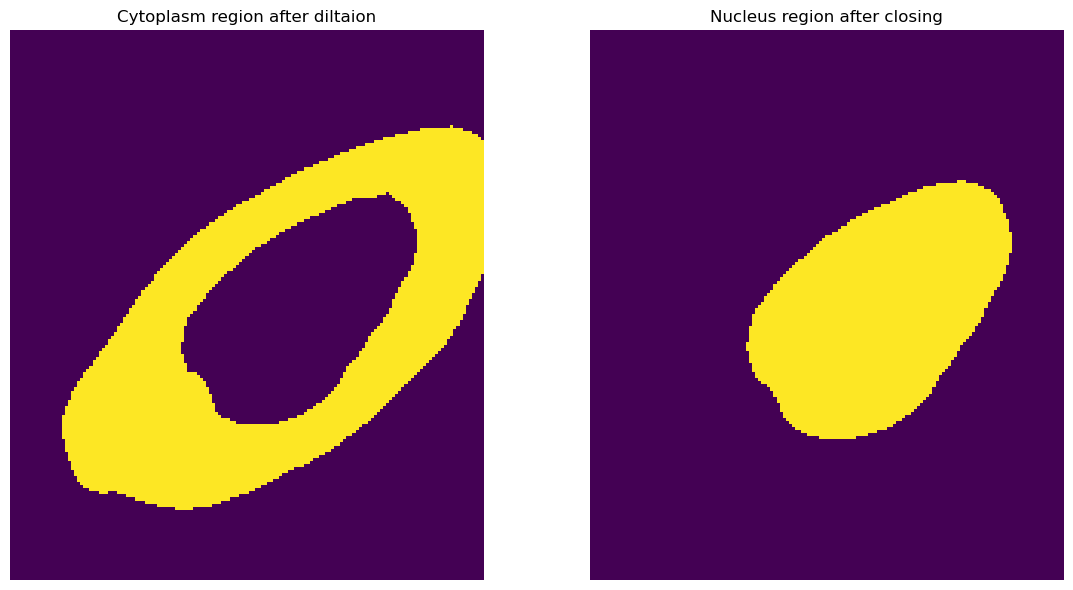

In [40]:
cytoplasm_mask = morphology.dilation(cytoplasm_mask_raw, footprint=morphology.disk(5))
nucleus_mask = morphology.opening(nucleus_mask_raw, footprint=morphology.disk(10))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask)
ax0.set_title('Cytoplasm region after diltaion')
ax0.axis('off')

ax1 = plt.subplot(122)  # "роздутий" регіон цитоплазми
ax1.imshow(nucleus_mask)
ax1.set_title('Nucleus region after closing')
ax1.axis('off')

plt.tight_layout()
plt.show()

Корегування фінальної маски цитоплазматичного регіону та побудова маски цілої клітини

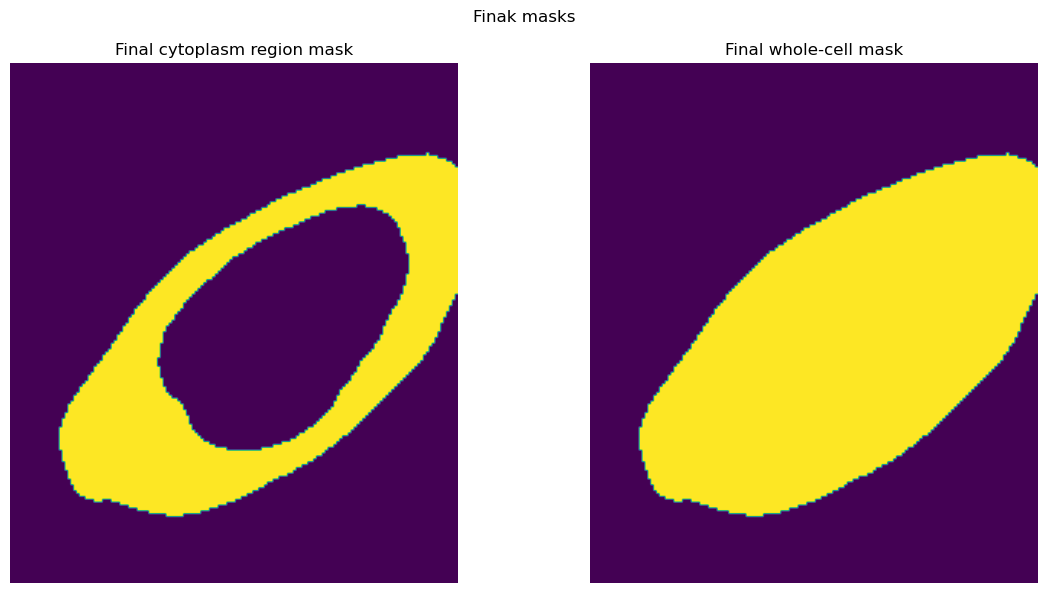

In [41]:
cytoplasm_mask[nucleus_mask] = 0
cell_mask = cytoplasm_mask + nucleus_mask


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # маска цитоплазматичног регіона
ax0.imshow(cytoplasm_mask)
ax0.set_title('Final cytoplasm region mask')
ax0.axis('off')

ax1 = plt.subplot(122)  # маска цілої клітини
ax1.imshow(cell_mask)
ax1.set_title('Final whole-cell mask')
ax1.axis('off')

plt.suptitle('Finak masks')
plt.tight_layout()
plt.show()

#### Фільтрування серій зображень обох каналів перед подальшою обробкою

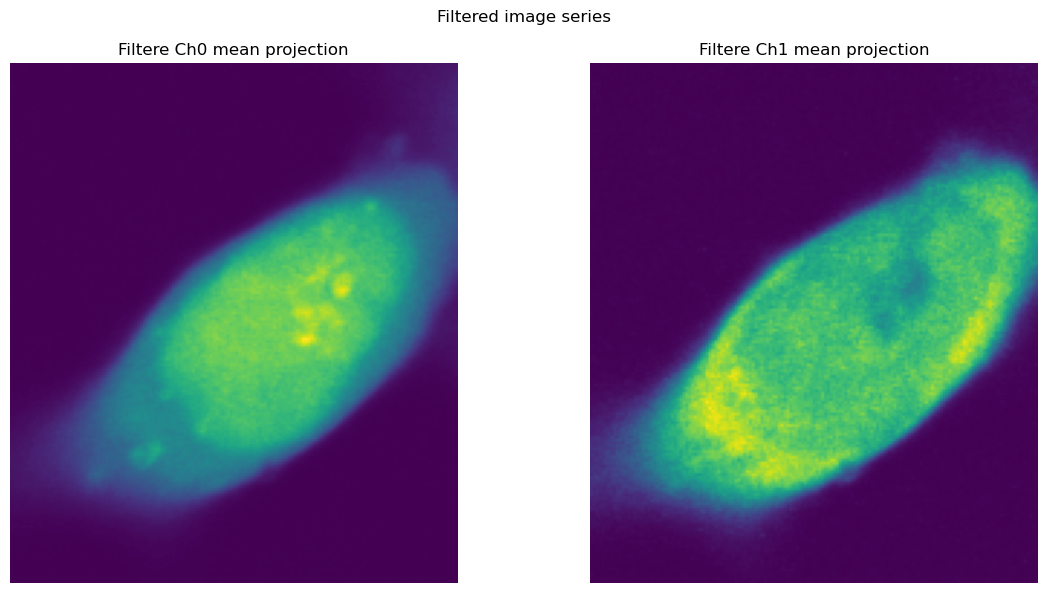

In [86]:
ch0_img_filtered = filters.gaussian(ch0_img_raw_crop, sigma=0.5, channel_axis=0)
ch1_img_filtered = filters.gaussian(ch1_img_raw_crop, sigma=0.5, channel_axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # маска цитоплазматичног регіона
ax0.imshow(np.mean(ch0_img_filtered, axis=0))
ax0.set_title('Filtere Ch0 mean projection')
ax0.axis('off')

ax1 = plt.subplot(122)  # маска цілої клітини
ax1.imshow(np.mean(ch1_img_filtered, axis=0))
ax1.set_title('Filtere Ch1 mean projection')
ax1.axis('off')

plt.suptitle('Filtered image series')
plt.tight_layout()
plt.show()

# 4. Детекція регіонів зміни інтенсивності
---

## Приклади

## Аналіз даних

#### Профіль похідної інтенсивності для визначення кадрів із стимуляціями 

Маскування клітини

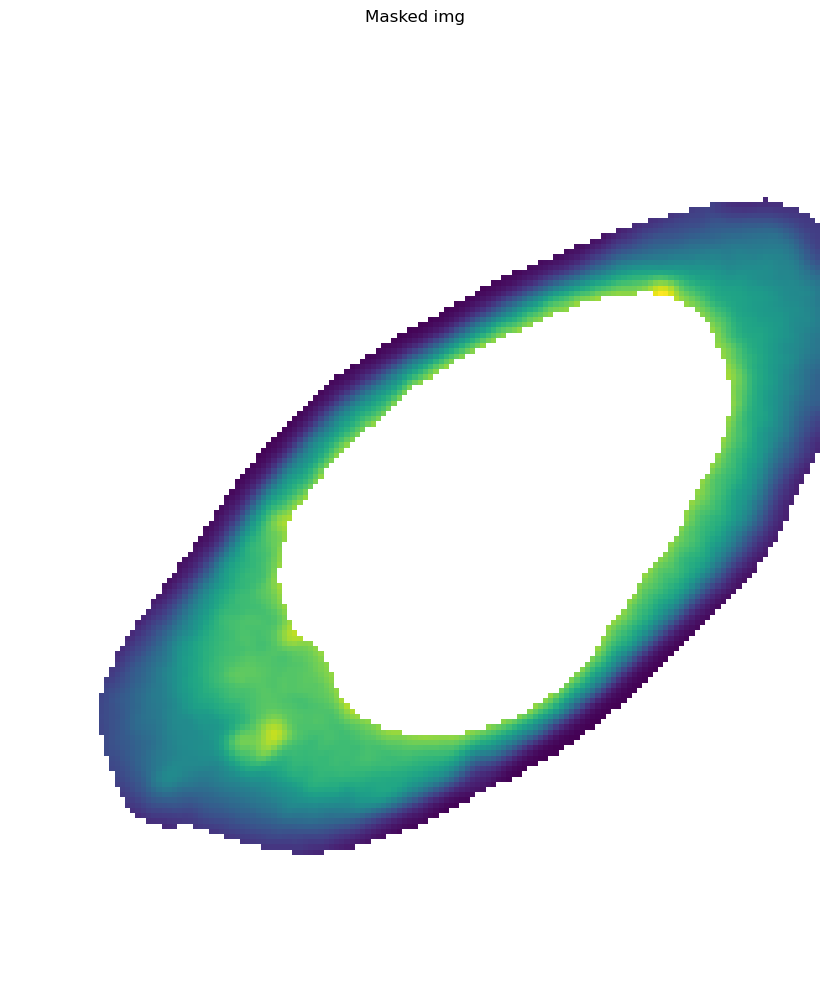

In [117]:
masked = ma.masked_where(~cytoplasm_mask, cell_det_img)


# plot
plt.figure(figsize=(10,10))
plt.imshow(masked)  # цитоплазамтичний регіон контрольного зображення канала кальцієвого барвника
plt.suptitle('Masked img')
plt.axis('off')
plt.tight_layout()
plt.show()

Профіль вицвітання в каналі флуоресцентного білка

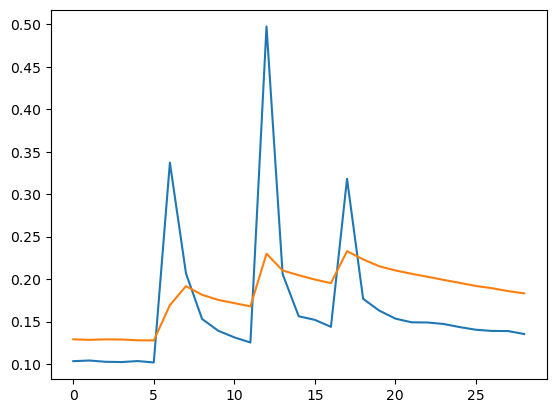

In [124]:
ch0_tot_prof = np.mean(ch0_img_filtered, axis=(1,2))  # профіль загальної інтенсивності для канала 0

ch0_der_prof = np.asarray([np.sum(np.abs(ma.masked_where(~cell_mask, frame)))
                           for frame in (ch0_img_filtered[:-1] - ch0_img_filtered[1:])])


plt.plot(ch0_der_prof/np.linalg.norm(ch0_der_prof))
plt.plot(ch0_tot_prof[1:]/np.linalg.norm(ch0_tot_prof[1:]))

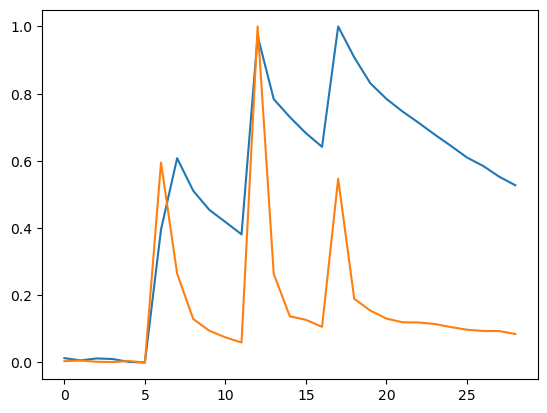

In [128]:
ch0_tot_prof_norm = (ch0_tot_prof - np.min(ch0_tot_prof))/(np.max(ch0_tot_prof)-np.min(ch0_tot_prof))
ch0_der_prof_norm = (ch0_der_prof - np.min(ch0_der_prof))/(np.max(ch0_der_prof)-np.min(ch0_der_prof))


plt.plot(ch0_tot_prof_norm[1:])
plt.plot(ch0_der_prof_norm)

In [100]:
ch1_tot_int_profile = np.mean(ch1_img_filtered, axis=(1,2))

ch1_native_int = np.mean(np.mean(ch1_img_filtered[:3], axis=0))
print(ch1_native_int)

0.005126767795976554


In [108]:
ch1_corr = np.asarray([frame * (ch1_native_int/np.sum(frame)) for frame in ch1_img_filtered])

In [109]:
ch1_corr.shape

(30, 180, 155)

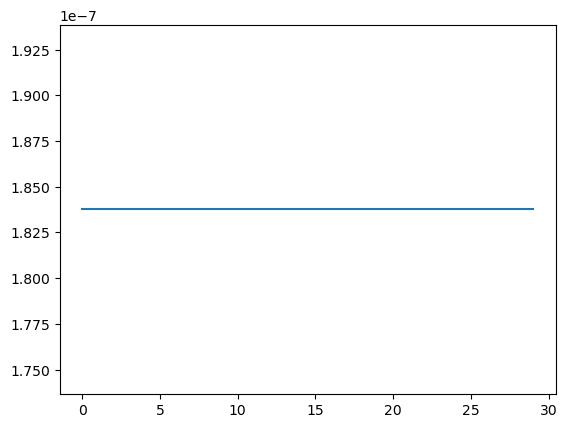

In [110]:
# plt.plot(ch1_tot_int_profile)
plt.plot(np.mean(ch1_corr, axis=(1,2)))

Маскування клітини

In [76]:
ch0_masked = np.asarray([ma.masked_where(~cytoplasm_mask, frame) for frame in ch0_img_filtered])
ch1_masked = np.asarray([ma.masked_where(~cell_mask, frame) for frame in ch1_img_filtered])

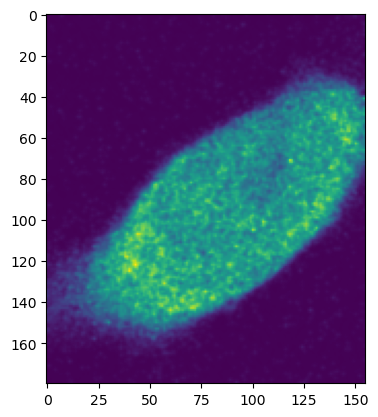

In [71]:
plt.imshow(ch1_masked[10])

Побудова профілю похідної інтенсивності для всього кадру

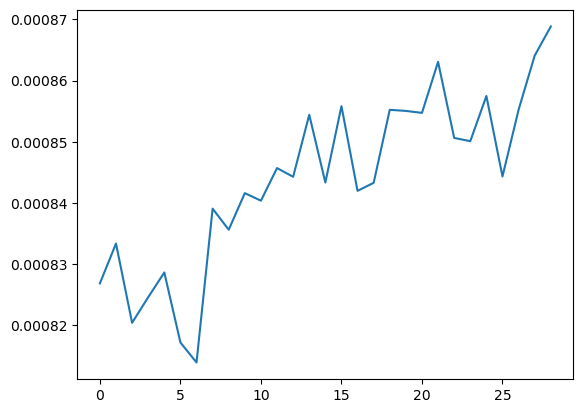

In [111]:
ch0_der_prof = np.asarray([np.sum(np.abs(frame))
                           for frame in (ch0_img_filtered[:-1] - ch0_img_filtered[1:])])

ch1_der_prof = np.asarray([np.sum(np.abs(frame))
                           for frame in (ch1_corr[:-1] - ch1_corr[1:])])

# plt.plot(ch0_der_prof)
plt.plot(ch1_der_prof)
plt.show()

Побудова профілю похідної інтенсивності для маскованих регіонів

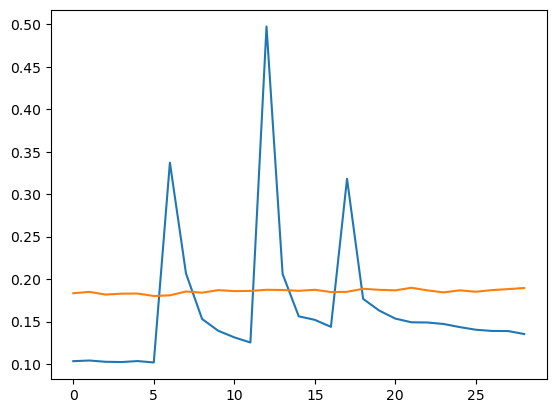

In [119]:
ch0_der_prof = np.asarray([np.sum(np.abs(ma.masked_where(~cell_mask, frame)))
                           for frame in (ch0_img_filtered[:-1] - ch0_img_filtered[1:])])

ch1_der_prof = np.asarray([np.sum(np.abs(ma.masked_where(~cell_mask, frame)))
                           for frame in (ch1_corr[:-1] - ch1_corr[1:])])

plt.plot(ch0_der_prof/np.linalg.norm(ch0_der_prof))
plt.plot(ch1_der_prof/np.linalg.norm(ch1_der_prof))
plt.show()

# 5. Побудова профілів за масками
---

# 6. Оцінка параметрів за допомогою лінійної моделі
---

In [ ]:
img_raw = io.imread('post_rgeco_mov_cor.tif')
img_bad = io.imread('post_rgeco.tif')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_bad, axis=0), cmap='jet')

plt.figure(figsize=(10,10))
plt.imshow(np.max(img_raw, axis=0), cmap='jet')

img = np.array([filters.gaussian(frame) for frame in img_raw])

print(img.shape)

In [ ]:
th_y = filters.threshold_yen(np.max(img, axis=0))
th_o = filters.threshold_otsu(np.max(img, axis=0))
th_l = filters.threshold_li(np.max(img, axis=0))

print(th_y, th_o, th_l)


img_max = np.max(img, axis=0)
plt.figure(figsize=(10,10))
plt.imshow(img_max, cmap='jet')

mask = img_max > th_y
crop_mask = mask[100:200, 100:200]
plt.figure(figsize=(10,10))
plt.imshow(mask)

label_mask = measure.label(mask)
plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap='jet')

In [ ]:
area_dict = {}
area_th = 150
for label_number in range(1, np.max(label_mask)):
    one_label_mask = label_mask == label_number
    one_label_area = np.sum(one_label_mask)
    
    if one_label_area >= area_th:
        label_area_dict = {label_number:one_label_area}
        area_dict.update(label_area_dict)

fin_mask = np.zeros_like(label_mask)
for lable_key in area_dict.keys():
     key_mask = label_mask == lable_key
     fin_mask = fin_mask + key_mask

fin_raw_mask = fin_mask
fin_mask = morphology.dilation(fin_mask, footprint=morphology.disk(6))
# plt.imshow(fin_raw_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)


fin_mask = measure.label(fin_mask)
plt.figure(figsize=(10,10))
plt.imshow(fin_mask)

#### Watershed segmentation

In [ ]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_cdt(fin_mask, metric='taxicab')
plt.figure(figsize=(10,10))
plt.imshow(distance)

# ndi.distance_transform_cdt, metric='taxicab'

coords = peak_local_max(distance, min_distance=15, footprint=morphology.disk(15), labels=fin_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=fin_mask)

plt.figure(figsize=(10,10))
plt.imshow(labels)

#### Profiles extration

In [ ]:
# profile = [np.mean(ma.masked_where(-fin_mask, frame)) for frame in img_raw]

plt.figure(figsize=(20, 8))

prof_arr = []
i = 0
for label in range(1, np.max(labels)+1):
    mask = labels == label
    prof = [np.mean(ma.masked_where(~mask, frame)) for frame in img_raw]
    prof_arr.append(prof)
    plt.plot(prof, label=label)
    i += 200

plt.legend()
plt.show()

prof_arr = np.asarray(prof_arr)

print(prof_arr.shape)


#### Demo labeling

In [ ]:
demo_mask = np.array([[1, 0, 1, 0],
                      [0, 0, 1, 1],
                      [0, 1, 0, 0],
                      [1, 0, 1, 0]])

label_demo_mask = measure.label(demo_mask, connectivity=1)

print(demo_mask)
print(label_demo_mask)
plt.imshow(label_demo_mask)

# Profile an

#### dF/F calc

In [ ]:
dF_prof_arr = []
for prof in prof_arr:
    F_0 = np.mean(prof[0:50])
    dF_prof = (prof - F_0)/F_0
    dF_prof_arr.append(dF_prof)

dF_prof_arr = np.asarray(dF_prof_arr)
plt.figure(figsize=(20, 8))
for dF_p in dF_prof_arr:
    plt.plot(dF_p)
plt.show()    
    
    

#### Peaks detection

In [ ]:
one_profile = dF_prof_arr[2]

peaks, properties = signal.find_peaks(one_profile,
                                      height=0.2,
                                      distance=5,
                                      wlen=30,
                                      prominence=0.15,
                                      rel_height=0.5,
                                      width=1)

print(peaks)
print(properties.keys())
print(properties)

In [ ]:

plt.figure(figsize=(20, 8))
plt.plot(one_profile)
plt.plot(peaks, one_profile[peaks], 'x')
